#### Objective
load the data in the _database_ and perform all the data manipulations such as blank absorbance and fluorescence blank substraction. Finally it saves the modified data in a new file.

In [1]:
# import general packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#modify some matplotlib parameters to manage the images for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import pickle as pkl

In [3]:
def save_obj(obj, name, folder ):
    with open(folder+'/'+ name + '.pkl', 'wb') as f:
        pkl.dump(obj, f, pkl.HIGHEST_PROTOCOL)

def load_obj(name, folder ):
    with open(folder+'/' + name + '.pkl', 'rb') as f:
        return pkl.load(f)

In [4]:
def non_redundant_list(labels):
    # make a list of non-redundant labels
    nr_labels=[]
    for label in labels:
        if label not in nr_labels:
            nr_labels.append(label)
    return(nr_labels)

In [5]:
def get_labelstrings(wsl, index_label, index, label_cathegories):
    # get the labels of the selected wells - datasets
    # index = well index number
    label_string=''
    for cat in label_cathegories:

        label_name = str(wsl[cat][index_label[index][0]][index_label[index][1]])
                
        if label_string == '':
            label_string = label_name
        else:
            label_string = label_string + ' , ' + label_name
        
    return(label_string)
            

In [6]:
def plot_group(wsd, wsl, datasheets, index_data, index_label, label_cath, y_axis_labels, log = False):
    """
    Plot the data from 'wsd' of wells indicated on 'index_data' putting the labels from 'label_cath' whos positions
    are indicated in 'index_label'.  
    
    Parameters
    ----------
    wsd: dictionary
        contain the data values of each well
    
    wsl:dictionary
        contain the labels of each well
        
    datasheets: list
        list of datasheet names. If you only put one name, make sure to make it a list
        e.g. ['sheet_name'] and not only 'sheetname'
    
    index_data: list
        contain the index of the selected data wells.
        can be obtained with get_group_index or set manually
        
    index_label: list
        coordinates of the selected wells in the label sheets
        can be obtained with get_group_index or set manually
    
    label_cath: list
        sheet names of the cathegories to use in the labels
    
    y_axis_labels: list
        y axis labels to write in the plots. It have to be in the same order
        as the data is included. 
        e.g: y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']
        
    
    Returns
    -------
    Plots of the desired data
        
    """
        
    data = {}
    labels = []
    ind_len = len(index_data)
    
    for name in datasheets:
        # make a list with arrays of zeros with the size of each dataset
        data[name] = np.zeros((wsd[name]['time'].shape[0], ind_len))

        # assign the corresponding values to each array
        for i in range(ind_len):
            data[name][:,i]=wsd[name]['data'][:,index_data[i]]
            
            # get the labels of the selected wells - datasets
            labels.append(get_labelstrings(wsl, index_label, i, label_cath))   
        
    print(labels)
    # make a list of non-redundant labels
    nr_labels = non_redundant_list(labels)

    # define a color vector for labels
    colors = plt.cm.jet(np.linspace(0, 1, len(nr_labels)))
    
    # make plots
   
    for name,m in zip(datasheets, range(len(y_axis_labels))):
        fig= plt.figure()
        fig.suptitle(name + ' series')
        plot_lines = []
        time=wsd[name]['time']
        
        for j in range(ind_len):
            lab_num = nr_labels.index(labels[j])       # get the position if the label in the non-redundant label list
            p=plt.plot(time, data[name][:,j], color=colors[lab_num])
            plot_lines.append(p)
        
        plt.ylabel(y_axis_labels[m])
        plt.xlabel('Time [hr]')
        if log == True:
            plt.yscale('log')
        #plt.axis([0, 6, 0, 20])
        plt.legend([nr_labels[i] for i in range(len(nr_labels))], loc = 'upper right', bbox_to_anchor=(1.3, 1))
        plt.show()

In [7]:
def get_group_index(label_groups, wsl, label_sheetnames):
    """
    Return the data index (well number) and the label index (label position) of the
    wells whose label coincide with at least one label of 'label_groups' (OR logic)
    In the future should be modified to choose between OR / AND logic classification
    accord the groups indicated in 'label_groups'
    
    Parameters
    ----------
    label_groups: list of strings
        contain the cathegories whose data sets are desired to select
        
    wsl: dictionary
        cointain the data from the workbook label sheets
    
    label_sheetnames: list of strings
        contain the names of the sheets with the labels
        
    
    Returns
    -------
    index_data: list
        contain the index of the selected data wells
        
    index_label: list
        coordinates of the selected wells in the label sheets
        
    """
    index_data=[]
    index_label=[]

    for cat in label_groups:
        for name in label_sheetnames:
            counter=0
            labels = wsl[name]
            for i in range(len(labels)):
                for j in range(len(labels[0])):
                    if cat == labels[i][j]:
                        index_data.append(counter)
                        index_label.append([i,j])
                    counter+=1    
    print(index_data)
    print(index_label)
    return(index_data, index_label)

In [8]:
def get_group_values(wsd, sheetnames, index_data, index_label):
    """
    Get the values of desired set of wells
    
    Parameters
    ----------
    wsd: dictionary
        contain the data values of each well
    
    sheetnames: list
        names of the data sheets
        
    index_data: list
        contain the index of the selected data wells.
        can be obtained with get_group_index or set manually
        
    
    Returns
    -------
    data: dictionary
        data of the desired wells. 
        Its estructure is: data[sheetname]['data' or 'time'] 
        
    """
    data = {}
    ind_len = len(index_data)
    
    for name in sheetnames:
        data[name] = {}
        
        data[name]['time'] = wsd[name]['time']
        data[name]['data'] = np.zeros((wsd[name]['time'].shape[0], ind_len))
        
        for i in range(ind_len):
            data[name]['data'][:,i]=wsd[name]['data'][:,index_data[i]]

    data['index'] = index_data
    data['index_lab'] = index_label
    return(data) 

In [9]:
def get_dict_cathegories(dictionary):
    cat_list = []
    for cat_name in dictionary.keys():
        cat_list.append(cat_name)
        
    return(cat_list)

In [10]:
def non_redundant_list(labels):
    # make a list of non-redundant labels
    nr_labels=[]
    for label in labels:
        if label not in nr_labels:
            nr_labels.append(label)
    return(nr_labels)

In [11]:
def get_labelstrings(wsl, index_label, index, label_cathegories):
    # get the labels of the selected wells - datasets
    # index = well index number
    label_string=''
    for cat in label_cathegories:

        label_name = str(wsl[cat][index_label[index][0]][index_label[index][1]])
                
        if label_string == '':
            label_string = label_name
        else:
            label_string = label_string + ' , ' + label_name
        
    return(label_string)

In [12]:
def plot_group(wsd, wsl, datasheets, index_data, index_label, label_cath, y_axis_labels, log = False):
    """
    Plot the data from 'wsd' of wells indicated on 'index_data' putting the labels from 'label_cath' whos positions
    are indicated in 'index_label'.  
    
    Parameters
    ----------
    wsd: dictionary
        contain the data values of each well
    
    wsl:dictionary
        contain the labels of each well
        
    datasheets: list
        list of datasheet names. If you only put one name, make sure to make it a list
        e.g. ['sheet_name'] and not only 'sheetname'
    
    index_data: list
        contain the index of the selected data wells.
        can be obtained with get_group_index or set manually
        
    index_label: list
        coordinates of the selected wells in the label sheets
        can be obtained with get_group_index or set manually
    
    label_cath: list
        sheet names of the cathegories to use in the labels
    
    y_axis_labels: list
        y axis labels to write in the plots. It have to be in the same order
        as the data is included. 
        e.g: y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']
        
    
    Returns
    -------
    Plots of the desired data
        
    """
        
    data = {}
    labels = []
    ind_len = len(index_data)
    
    for name in datasheets:
        # make a list with arrays of zeros with the size of each dataset
        data[name] = np.zeros((wsd[name]['time'].shape[0], ind_len))

        # assign the corresponding values to each array
        for i in range(ind_len):
            data[name][:,i]=wsd[name]['data'][:,index_data[i]]
            
            # get the labels of the selected wells - datasets
            labels.append(get_labelstrings(wsl, index_label, i, label_cath))   
        
    print(labels)
    # make a list of non-redundant labels
    nr_labels = non_redundant_list(labels)

    # define a color vector for labels
    colors = plt.cm.jet(np.linspace(0, 1, len(nr_labels)))
    
    # make plots
   
    for name,m in zip(datasheets, range(len(y_axis_labels))):
        fig= plt.figure()
        fig.suptitle(name + ' series')
        plot_lines = []
        time=wsd[name]['time']
        
        for j in range(ind_len):
            lab_num = nr_labels.index(labels[j])       # get the position if the label in the non-redundant label list
            p=plt.plot(time, data[name][:,j], color=colors[lab_num])
            plot_lines.append(p)
        
        plt.ylabel(y_axis_labels[m])
        plt.xlabel('Time [hr]')
        if log == True:
            plt.yscale('log')
        #plt.axis([0, 6, 0, 20])
        plt.legend([nr_labels[i] for i in range(len(nr_labels))], loc = 'upper right', bbox_to_anchor=(1.3, 1))
        plt.show()

In [13]:
def get_group_index(label_groups, wsl, label_sheetnames):
    """
    Return the data index (well number) and the label index (label position) of the
    wells whose label coincide with at least one label of 'label_groups' (OR logic)
    In the future should be modified to choose between OR / AND logic classification
    accord the groups indicated in 'label_groups'
    
    Parameters
    ----------
    label_groups: list of strings
        contain the cathegories whose data sets are desired to select
        
    wsl: dictionary
        cointain the data from the workbook label sheets
    
    label_sheetnames: list of strings
        contain the names of the sheets with the labels
        
    
    Returns
    -------
    index_data: list
        contain the index of the selected data wells
        
    index_label: list
        coordinates of the selected wells in the label sheets
        
    """
    index_data=[]
    index_label=[]

    for cat in label_groups:
        for name in label_sheetnames:
            counter=0
            labels = wsl[name]
            for i in range(len(labels)):
                for j in range(len(labels[0])):
                    if cat == labels[i][j]:
                        index_data.append(counter)
                        index_label.append([i,j])
                    counter+=1    
    print(index_data)
    print(index_label)
    return(index_data, index_label)

In [14]:
def get_group_values(wsd, sheetnames, index_data, index_label):
    """
    Get the values of desired set of wells
    
    Parameters
    ----------
    wsd: dictionary
        contain the data values of each well
    
    sheetnames: list
        names of the data sheets
        
    index_data: list
        contain the index of the selected data wells.
        can be obtained with get_group_index or set manually
        
    
    Returns
    -------
    data: dictionary
        data of the desired wells. 
        Its estructure is: data[sheetname]['data' or 'time'] 
        
    """
    data = {}
    ind_len = len(index_data)
    
    for name in sheetnames:
        data[name] = {}
        
        data[name]['time'] = wsd[name]['time']
        data[name]['data'] = np.zeros((wsd[name]['time'].shape[0], ind_len))
        
        for i in range(ind_len):
            data[name]['data'][:,i]=wsd[name]['data'][:,index_data[i]]

    data['index'] = index_data
    data['index_lab'] = index_label
    return(data) 

In [15]:
def subtract_od_blank(wsd, od_sheet_name, blank_value):
    od600 = wsd[od_sheet_name]['data']
    od600 = od600 - blank_value
    
    for i in range(od600.shape[0]):
        for j in range(od600.shape[1]):
            if od600[i,j] < 0.0005:
                od600[i,j] = 0.0005    # the minimum value is set to be 0.005 (as we start from 1:1000 bacterial dilution)
    return(od600)

In [16]:
def plot_dat_dat(wsd, x_sheetname, y_sheetname, x_units, y_units, label_cath, wsl, index_dat = '', index_lab = '', x_logscale=False, y_logscale = False):
    
    # define the well data index and well label index
    if index_dat == '': 
        wells = wsd['index']
    else:
        wells = index_dat
        
    if index_lab == '':
        index_label = wsd['index_lab']
    else:
        index_label = index_lab
    
    if len(wells) != len(index_label):
        print('ERROR: Wells index data and wells index label have to be same length!')
        return
    
    # get the data
    labels = []
    wells_num = len(wsd[x_sheetname]['data'][0,:])
    data = np.zeros((len(wsd[x_sheetname]['data'][:,0]), 2, wells_num))
        
    for i in range(wells_num):

        data[:,0,i] = wsd[x_sheetname]['data'][:,i]
        data[:,1,i] = wsd[y_sheetname]['data'][:,i]
        labels.append(get_labelstrings(wsl, index_label, i, label_cath))   
    
    # make a list of non-redundant labels
    nr_labels = non_redundant_list(labels)

    # define a color vector for labels
    colors = plt.cm.jet(np.linspace(0, 1, len(nr_labels)))
    
    fig= plt.figure()
    fig.suptitle(x_sheetname + ' v/s '+ y_sheetname)
   
    for j in range(wells_num):
        lab_num = nr_labels.index(labels[j])       # get the position if the label in the non-redundant label list
        p=plt.plot(data[:,0,j], data[:,1,j], color=colors[lab_num])
    
    plt.ylabel(y_sheetname +' '+ str(y_units))
    plt.xlabel(x_sheetname +' '+ str(x_units))
    plt.legend([nr_labels[i] for i in range(len(nr_labels))], loc = 'upper right', bbox_to_anchor=(1.3, 1))
    #plt.axis([0, 6, 0, 20])
    if x_logscale == True:
        plt.xscale('log')
        
    if y_logscale == True:
        plt.yscale('log')        
    
    plt.show()
    
    return(data)



In [17]:
def sort_matrix(data, col_name):
    # sort the values
    # scol = column used to determine the sorting
    # data: dictionary which contains:
    #      'matrix' = matrix to be sorted
    #      'column_names' = matrix to be sorted
    # matrix_sort_col = matrix sorted based on the 'scol' column
    
    scol=data['column_names'].index(col_name)
    matrix = data['matrix']
    
    # perform the matrix sorting
    matrix_sort_col = np.zeros((matrix.shape))
    matrix_sort = np.sort(matrix,0)  # each column is sorted independently

    for i in range(matrix_sort.shape[0]):
        for j in range(matrix.shape[0]):
                   
            if matrix_sort[i,scol] == matrix[j,scol]:
                matrix_sort_col[i,:] = matrix[j,:]
                matrix = np.delete(matrix, j, 0)
                break
    
    # store the data
    sorted_data = data
    sorted_data['matrix'] = matrix_sort_col
    return(sorted_data)

In [18]:
def group_sheet_values(wells_data, data_sheets):
    # this function put all the data of data_sheets on one matrix, where each sheet is put in a colum (data of
    # each well is one under other on the same column) with length = wells number * time points.
    # wells_data = matrix with the data of wells in each column. e.g. = data['OD600']['data'].shape[0]
    # data_sheets: data sheet labels list. e.g ['OD600','CFP','YFP']
    
    group_data={}
    times = wells_data[data_sheets[0]]['data'].shape[0]
    wells = wells_data[data_sheets[0]]['data'].shape[1]

    group_data['matrix'] = np.zeros((times*wells,len(data_sheets)))
    for i in range(wells):
        for j in range(len(data_sheets)):
            group_data['matrix'][i*times:(i+1)*times,j]=wells_data[data_sheets[j]]['data'][:,i]
    
    group_data['column_names'] = data_sheets
    
    return(group_data)

In [19]:
def pol_fitting(sheetx, sheety, data_matrix, pol_deg, fname = 'null'):
    # sort the values
    sorted_matrix = sort_matrix(data_matrix, data_sheets[0])
    sheetx_index = sorted_matrix ['column_names'].index(sheetx)
    sheety_index = sorted_matrix ['column_names'].index(sheety)

    # fitting
    x=sorted_matrix['matrix'][:,sheetx_index]
    y=sorted_matrix['matrix'][:,sheety_index]
    z=np.polyfit(x,y,pol_deg)
    function_name = 'f('+sheetx+')'
    polynomial = np.poly1d(z)


    # plot
    fig= plt.figure()
    pdat = plt.plot(x,y,'x',color='b')
    pfit = plt.plot(x,polynomial(x),color='r')
    plt.legend((pdat[0], pfit[0]), ('Data', 'polynomial fit'))
    plt.ylabel(sheety)
    plt.xlabel(sheetx)
    
    if fname != 'null':
        plt.savefig(str(fname)+".png",bbox_inches='tight') #

    return(function_name, np.poly1d(z))

In [20]:
def subtract_fluo_blank(wsd, fluo_blank, y_sheet_names, xsheet, plot = True, fname = 'null'):
    
    xdat = wsd[xsheet]['data']
    
    for sheet in y_sheet_names:
        ydat = wsd[sheet]['data']
        
        # evaluate the fluo blank function in each xdata point
        yblank = fluo_blank[sheet]['f('+xsheet+')'](xdat)
        ysub=np.zeros((yblank.shape))
        
        # perform the substraction
        for i in range(yblank.shape[0]):
            for j in range(yblank.shape[1]):
                ysub[i,j] = ydat[i,j] - yblank[i,j]
                
                # make sure any value is under 1
                if ysub[i,j] < 1:
                    ysub[i,j] = 1
        
        # replace the new computed value in the data dictionary
        wsd[sheet]['data'] = ysub
        
        # make the plot if it is desired
        if plot == True:
            fig= plt.figure()
            pdat = plt.plot(xdat,ydat,'b')
            pblank = plt.plot(xdat,yblank,'g')
            psub = plt.plot(xdat,ysub,'r')
            plt.xlabel(xsheet)
            plt.ylabel(sheet)
            plt.title(sheet)
            plt.legend((pdat[0], pblank[0], psub[0]), ('Data', 'Computed Blank', 'Blank subtracted'))
            
            if fname != 'null':
                plt.savefig(str(fname)+".png",bbox_inches='tight') #
        
    return(wsd)
        

In [21]:
all_data = load_obj('rdatabase', 'data' )

In [22]:
all_data['Placa v2 - 01- python.xlsx']['label_sheets'].keys()

dict_keys(['Strains', 'Level', 'Plasmid', 'Media'])

In [23]:
file_names = get_dict_cathegories(all_data)

### Run from here to each plate file in file_names

In [24]:
plate_num = 2 # filename position number
wdata = all_data[file_names[plate_num]]['data_sheets']
wlabels = all_data[file_names[plate_num]]['label_sheets']

get the cathegories names in each dictionary

In [25]:
data_sheets = get_dict_cathegories(wdata)
label_sheets = get_dict_cathegories(wlabels)

let's take a general view

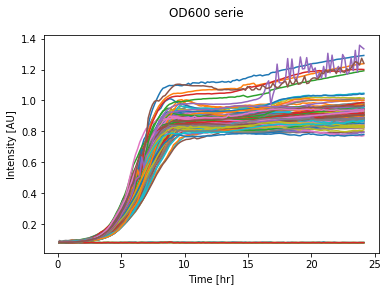

In [26]:
# put here the data name you are interested
data_name=data_sheets[0]   #only change the number inside []

# now it will be plot
fig= plt.figure()
fig.suptitle(data_name +' serie')
plt.plot(wdata[data_name]['time'], wdata[data_name]['data'])
plt.ylabel('Intensity [AU]')
plt.xlabel('Time [hr]')
#plt.axis([0, 6, 0, 20])
plt.show()

Now start to identify and substact the values of:
1. Absorbance blank
2. Fluorescence blank

#### 1 ) Absorbance blank

Blank wells are those whose have only M9-Glycerol medium without have been inoculated

[78, 79, 80, 81, 82, 83]
[[6, 6], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11]]
['Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -', 'Blank ,  -']


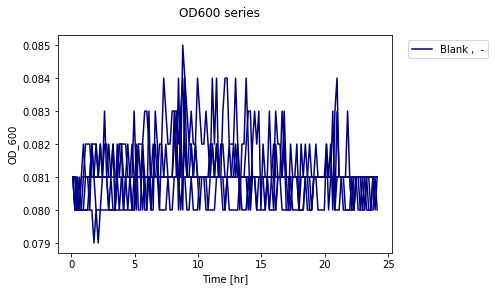

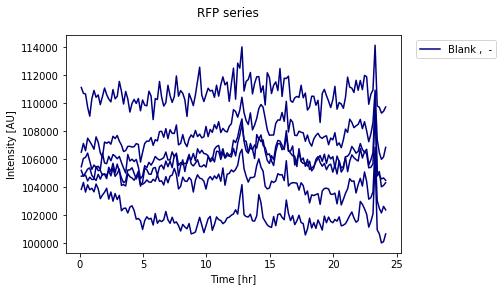

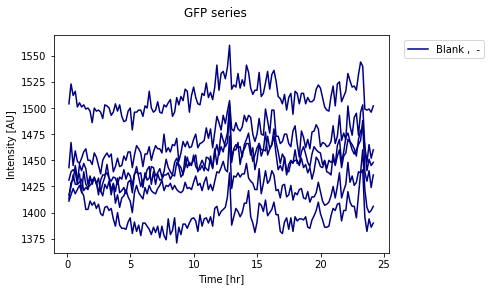

In [27]:
#define the OD blank data series
b_labels=['Blank']  #fill this list manually

# and get the wells index which have that lalbels
index_D, index_L = get_group_index(b_labels, wlabels, label_sheets)

#Perform the plots of blank series data
legend_labels = [label_sheets[0], label_sheets[1]]
y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']

plot_group(wdata, wlabels, [data_sheets[0],data_sheets[1],data_sheets[2]], index_D, index_L, legend_labels, y_axis_labels)

As the OD blank values are tiny and roughtly constants, it's possible to condense them as only one value given by the mean of all of them.

In [28]:
od_blank_vals = get_group_values(wdata, data_sheets, index_D, index_L)
print(od_blank_vals['OD600']['data'].shape)

od_bval=od_blank_vals['OD600']['data'].mean(axis=(0,1))
print(od_bval)

(145, 6)
0.08100919540229884


run the next square just one time! otherwise you will substract blank value twice

In [29]:
wdata_b = wdata
wdata_b['OD600']['data'] = subtract_od_blank(wdata_b, data_sheets[0], od_bval)

#### 2)  Fluorescence blank values

For this aim, it's necessary to analyse the **_Fluorescent blank series_** .
In this case there are different blank series for each fluorescent protein. Exactly, for:
* RFP: Top10 with pCAL1-4_sfGFP (to include the possible bleed-through)
* GFP: AKR1

In [30]:
#define the Fluorescent blank data series
Gfb_labels=['AKR1']  #fill this list manually
Rfb_labels=['pCAL1_sfGFP (TOP10)']  #fill this list manually
#[G_blank, R_blank]

[84, 85, 86, 87, 88, 89]
[[7, 0], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5]]
['AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1', 'AKR1']


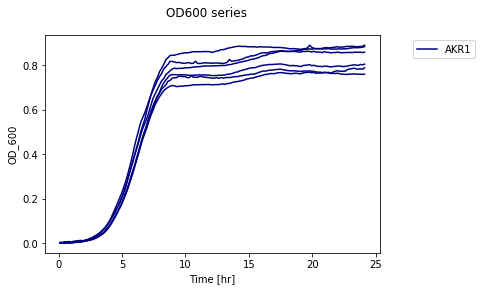

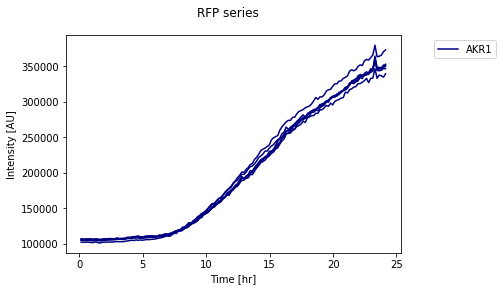

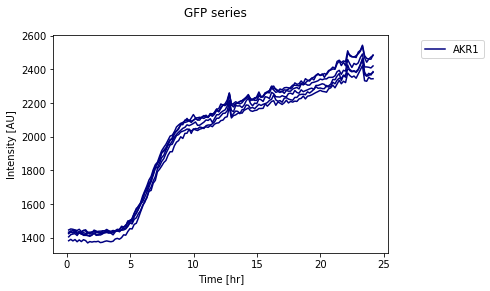

In [31]:
# and get the wells index which have that lalbels
Gindex_d, Gindex_l = get_group_index(Gfb_labels, wlabels, label_sheets)

#Perform the plots of blank series data
legend_labels = [label_sheets[0]]
y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']

plot_group(wdata_b, wlabels, data_sheets, Gindex_d, Gindex_l, legend_labels, y_axis_labels)


[90, 91, 92, 93, 94, 95]
[[7, 6], [7, 7], [7, 8], [7, 9], [7, 10], [7, 11]]
['pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)', 'pCAL1_sfGFP (TOP10)']


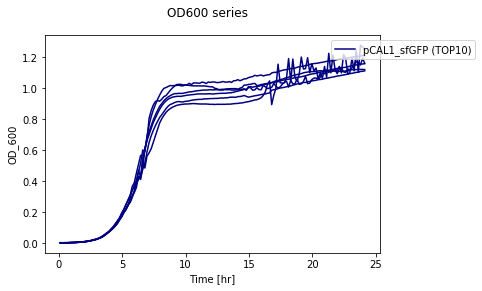

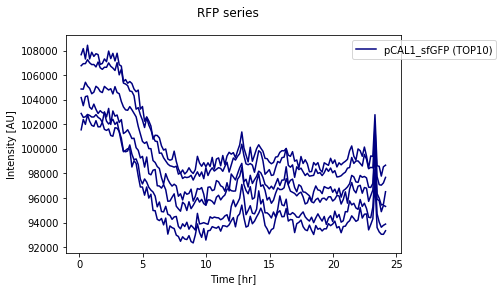

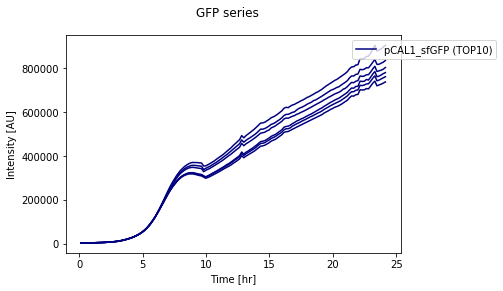

In [32]:
# and get the wells index which have that lalbels
Rindex_d, Rindex_l = get_group_index(Rfb_labels, wlabels, label_sheets)

#Perform the plots of blank series data
legend_labels = [label_sheets[0]]
y_axis_labels = ['OD_600', 'Intensity [AU]','Intensity [AU]']

plot_group(wdata_b, wlabels, data_sheets, Rindex_d, Rindex_l, legend_labels, y_axis_labels)

And get the values of those data

In [33]:
fluo_Rblank = get_group_values(wdata_b, data_sheets, Rindex_d, Rindex_l)
fluo_Gblank = get_group_values(wdata_b, data_sheets, Gindex_d, Gindex_l)

Now we should get an empiric funtion to relate growth and basal fluorescent signal

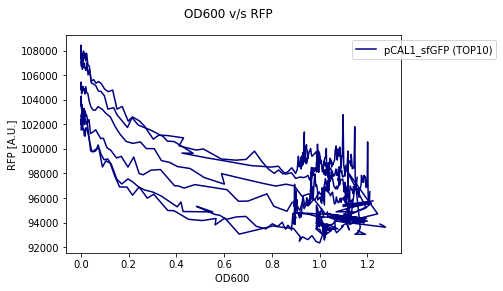

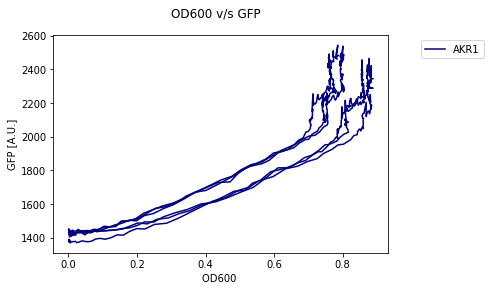

In [34]:
legend_labels = [label_sheets[0]]
_ = plot_dat_dat(fluo_Rblank,'OD600','RFP', '','[A.U.]', legend_labels, wlabels)
_ = plot_dat_dat(fluo_Gblank,'OD600','GFP', '','[A.U.]', legend_labels, wlabels)

We can fit an empiric polynomial function to these values using 'polyfit'. To this aim, it's necessary to have all the data in one sorted matrix (otherwise fitting makes weird wheels).

In [35]:
Rfb_matrix = group_sheet_values(fluo_Rblank, data_sheets)

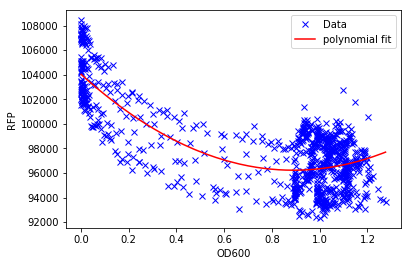

In [36]:
sheet_x = data_sheets[0]
sheet_y = data_sheets[1]
pol_deg = 2
func_name, fluo_Rblank[sheet_y][func_name] = pol_fitting(sheet_x, sheet_y, Rfb_matrix, pol_deg, fname = 'pCAL1_sfGFP_RFP-OD_'+str(plate_num))

In [37]:
Gfb_matrix = group_sheet_values(fluo_Rblank, data_sheets)

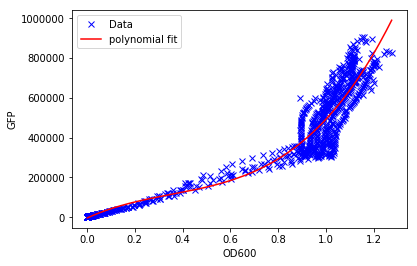

In [38]:
sheet_x = data_sheets[0]
sheet_y = data_sheets[2]
pol_deg = 3

func_name, fluo_Gblank[sheet_y][func_name] = pol_fitting(sheet_x, sheet_y, Gfb_matrix, pol_deg, fname = 'AKR1_'+str(plate_num))

Now it's time to substract those values

wdata2 now contain the values in red lines


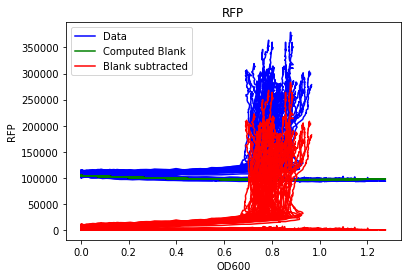

In [39]:
# R blanks subtraction
wdata2=subtract_fluo_blank(wdata_b, fluo_Rblank, ['RFP'], 'OD600', fname = 'RFP_blank_subs_'+str(plate_num))  
print('wdata2 now contain the values in red lines')

wdata2 now contain the values in red lines


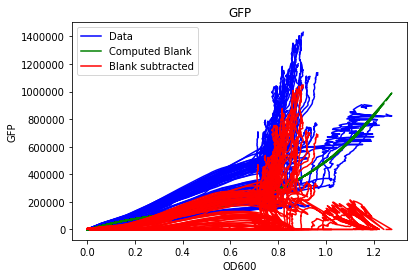

In [40]:
# G blanks subtraction
wdata2=subtract_fluo_blank(wdata_b, fluo_Gblank, ['GFP'], 'OD600',fname = 'GFP_blank_subs_'+str(plate_num))  
print('wdata2 now contain the values in red lines')

Finally replace the data on the database object

In [198]:
all_data[file_names[plate_num]]['data_sheets'] = wdata2

##### save the data

In [199]:
def save_obj(obj, name, folder ):
    with open(folder+'/'+ name + '.pkl', 'wb') as f:
        pkl.dump(obj, f, pkl.HIGHEST_PROTOCOL)

In [200]:
save_obj(all_data, 'managed_database', 'data')

In [205]:
all_data[file_names[0]]['data_sheets']['OD600']['data']

array([[5.00000000e-04, 5.00000000e-04, 5.00000000e-04, ...,
        5.00000000e-04, 1.35862069e-03, 1.35862069e-03],
       [5.00000000e-04, 5.00000000e-04, 5.00000000e-04, ...,
        5.00000000e-04, 1.35862069e-03, 5.00000000e-04],
       [5.00000000e-04, 1.35862069e-03, 1.35862069e-03, ...,
        5.00000000e-04, 1.35862069e-03, 1.35862069e-03],
       ...,
       [8.18358621e-01, 8.02358621e-01, 7.80358621e-01, ...,
        1.06035862e+00, 1.09235862e+00, 1.03235862e+00],
       [8.18358621e-01, 8.04358621e-01, 7.83358621e-01, ...,
        1.06235862e+00, 1.09435862e+00, 1.03435862e+00],
       [8.19358621e-01, 8.05358621e-01, 7.82358621e-01, ...,
        1.06435862e+00, 1.09635862e+00, 1.03735862e+00]])